# plt_pie
- sns no tiene nada de pie no donuts charts
- Este es el último arch de pie

## TO-DO
- Add value_counts para casos donde que aggregate categories
- Nuevo etiquetado full_ext, para cuando los sectores sean muy chicos 
- ANALIZAR! el tema de poner o no títulos por default

In [3]:
## Standard Libs
from typing import Union, Optional, Literal, Any, Sequence, TypeAlias
import warnings
import random

# Third-Party Libs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import seaborn as sns

# # Local Libs
# from jm_datascience import jm_pandas as jm_pd
# from jm_datascience import jm_pdaccessor as jm
# from jm_utils import jm_richprt as jm_prt

# Type Aliases
IndexElement: TypeAlias = Union[str, int, float, pd.Timestamp]

## Some Series and DFs

In [4]:
df_work = pd.DataFrame({
    'nombre': ['Ana', 'Bob', '', 'Carlos', ' ', 'Diana'],
    'apellido': ['A_Ana', 'B_Bob', None, 'C_Carlos', None, 'D_Diana'],
    'edad': [25, -1, 30, 999, 28, 22],
    'ciudad': ['Madrid', 'N/A', 'Barcelona', 'Valencia', 'unknown', 'Sevilla'],
    'salario': [50000, 0, 60000, -999, 55000, 48000]
})

## Read spreedsheet for tests
try:
    spreedsheet = r"C:\Users\jm\Documents\__Dev\PortableGit\__localrepos\365DS_jm\3_statistics\2_13_Practical_Ex_Descriptive_Stats.xlsx"    # Casa
    with open(spreedsheet) as f:
        pass
except FileNotFoundError:
    spreedsheet = r"D:\git\PortableGit\__localrepos\365DS_jm\3_statistics\2_13_Practical_Ex_Descriptive_Stats.xlsx"                         # Office

df_xls = pd.read_excel(spreedsheet, skiprows=4, usecols='B:J,L:AA', index_col='ID')
df = df_xls.copy()

lst_str = random.choices([chr(i) for i in range(65, 72)], k=175)
# sr_str = jm_pd.to_series(lst_str)                         # <- jm_pd.to_serie_with_count()

In [5]:
def _fmt_value_for_pd(value, width=8, decimals=2, miles=',') -> str:
    """
    Format a value (numeric or string) into a right-aligned string of fixed width.

    Converts numeric values to formatted strings with thousands separators and
    specified decimal places. Strings are padded to the same width for consistent alignment.

    Parameters:
        value (int, float, str): The value to be formatted.
        width (int): Total width of the output string. Must be a positive integer.
        decimals (int): Number of decimal places for numeric values. Must be >= 0.
        miles (str or None): Thousands separator. Valid options: ',', '_', or None.

    Returns:
        str: The formatted string with right alignment.

    Raises:
        ValueError: If width <= 0, decimals < 0, or miles is invalid.

    Examples:
        >>> format_value(123456.789)
        '123,456.79'
        >>> format_value("text", width=10)
        '      text'
        >>> format_value(9876, miles=None)
        '    9876.00'
    """
    # Parameter Value validation <- vamos a tener que analizar este tema por si es un list , etc,,
    #   - En realidad acá tenemos que evaluar algo similar a jm_utils - fmt_values() FUTURE
    # if not isinstance(value, (int, float, np.integer, np.floating)) or pd.api.types.is_any_real_numeric_dtype(value)

    if not isinstance(width, int) or width <= 0:
        raise ValueError(f"Width must be a positive integer. Not '{width}'")
    
    if not isinstance(decimals, int) or decimals < 0:
        raise ValueError(f"Decimals must be a non-negative integer. Not '{decimals}")
    
    if miles not in [',', '_', None]:
        raise ValueError(f"Miles must be either ',', '_', or None. Not '{miles}")
    
    try:
        num = float(value)                                  # Convert to float if possible
        if num % 1 == 0:                                    # it its a total integer number
            decimals = 0
        if miles:
            return f"{num:>{width}{miles}.{decimals}f}"     # Ancho fijo, x decimales, alineado a la derecha
        else:
            return f"{num:>{width}.{decimals}f}"
        
    except (ValueError, TypeError):
        return str(value).rjust(width)                      # Alinea también strings, para mantener la grilla

In [6]:
def _validate_numeric_series(
        pd_data: Union[pd.Series, pd.DataFrame],
        positive: Optional[bool] = True
) -> Union[None, Exception]:

    # Validate data parameter a pandas object
    if not isinstance(pd_data, (pd.Series, pd.DataFrame)):     # pd.Series or pd.Datafram
        raise TypeError(
            f"Input data must be a pandas Series or DataFrame. Got {type(pd_data)} instead."
        )
              
    if positive:
        if not all(                                             # Only positve numeric values
            isinstance(val, (int, float, np.integer, np.floating)) and val > 0 for val in pd_data.values
        ):
            raise ValueError(f"All values in the data must be positive numeric..")
        pass
    else:                                                       # Just only numeric values
        if not all(isinstance(val, (int, float, np.integer, np.floating)) for val in pd_data.values):
            raise ValueError(f"All values in the data must be numeric values.")
        pass

In [7]:
def to_series(
    data: Union[pd.Series, np.ndarray, dict, list, set, pd.DataFrame],
    index: Optional[Union[pd.Index, Sequence[IndexElement]]] = None,
    name: Optional[str] = None
) -> pd.Series:
    """
    Converts input data into a pandas Series with optional custom index and name.

    This function standardizes various data types into a pandas Series. It supports
    arrays, dictionaries, lists, sets, DataFrames, and existing Series. Optionally,
    a custom index or series name can be assigned.

    Parameters:
        data (Union[pd.Series, np.ndarray, dict, list, set, pd.DataFrame]):
            Input data to convert. Supported types:
            - pd.Series: returned as-is (can be overridden with new index/name).
            - np.ndarray: flattened and converted to a Series.
            - dict: keys become the index, values become the data.
            - list or set: converted to a Series with default integer index.
            - pd.DataFrame:
                - 1 column: converted directly to a Series.
                - 2 columns: first column becomes the index, second becomes the values.
        index (Union[pd.Index, Sequence], optional): Custom index to assign to the Series.
            If provided, overrides the original index. Default is None.
        name (str, optional): Name to assign to the Series. Default is None.

    Returns:
        pd.Series: A pandas Series constructed from the input data, with optional
            custom index and name.

    Raises:
        TypeError: If the input data type is not supported.
        ValueError: If the DataFrame has more than 2 columns.

    Examples:
        >>> import pandas as pd
        >>> to_series([1, 2, 3, 4])
        0    1
        1    2
        2    3
        3    4
        dtype: int64

        >>> to_series({'A': 10, 'B': 20, 'C': 30})
        A    10
        B    20
        C    30
        dtype: int64

        >>> df = pd.DataFrame({'Label': ['X', 'Y'], 'Value': [100, 200]})
        >>> to_series(df)
        Label
        X    100
        Y    200
        Name: Value, dtype: int64

        >>> to_series([10, 20, 30], index=['a', 'b', 'c'], name='Measurements')
        a    10
        b    20
        c    30
        Name: Measurements, dtype: int64
    """
    
    # Validate parameters - FUTURE
    
    if isinstance(data, pd.Series):                 # If series is already a Series no conversion needed
        series = data                                  
    elif isinstance(data, np.ndarray):              # If data is a NumPy array   
        series = pd.Series(data.flatten())
    elif isinstance(data, (dict, list)):
        series = pd.Series(data)
    elif isinstance(data, (set)):
        series = pd.Series(list(data))
    elif isinstance(data, pd.DataFrame):
        if data.shape[1] == 1:                      # Also len(data.columns == 1)
            series = data.iloc[:, 0]
        elif data.shape[1] == 2:                    # Index: first col, Data: 2nd Col
            series = data.set_index(data.columns[0])[data.columns[1]]
        else:
            raise ValueError("DataFrame must have 1 oer 2 columns. Categories and values for 2 columns cases.")
    else:
        raise TypeError(f"Unsupported data type: {type(data)}. "
                    "Supported types: pd.Series, np.ndarray, pd.DataFrame, dict, list, set, and pd.DataFrame")

    if name:
        series.name = name

    if index:
        series.index = index

    return series

In [8]:
def get_fdt(
        data: Union[pd.Series, np.ndarray, dict, list, set, pd.DataFrame],
        value_counts: Optional[bool] = False,
        dropna: Optional[bool] = True,
        na_position: Optional[str] = 'last',
        include_pcts: Optional[bool] = True,
        include_plain_relatives: Optional[bool] = True,
        fmt_values: Optional[bool] = False,
        order: Optional[str] = 'desc',
        na_aside_calc: Optional[bool] = True
) -> pd.DataFrame:
    """
    Generates a Frequency Distribution Table (FDT) with absolute, relative, and cumulative frequencies.
        Handles NaN values and allows for various configurations

    This function converts various input data types into a structured DataFrame containing:
    - Absolute frequencies
    - Cumulative frequencies
    - Relative frequencies (proportions and percentages)
    - Cumulative relative frequencies (percentages)

    Parameters:
        data (Union[pd.Series, np.ndarray, dict, list, pd.DataFrame]): Input data.
            If DataFrame, it will be converted to a Series using `to_series`.
        value_counts (bool, optional): Whether to count occurrences if input is raw data.
            Assumes data is not pre-counted. Default is False.
        dropna (bool, optional): Whether to exclude NaN values when counting frequencies.
            Default is True.
        na_position (str, optional): Position of NaN values in the output:
            - 'first': Place NaN at the top.
            - 'last': Place NaN at the bottom (default).
            - 'value': Keep NaN in its natural order.
            Default is 'last'.
        include_pcts (bool, optional): Whether to include percentage columns.
            If False, only absolute and cumulative frequencies are returned.
            Default is True.
        include_plain_relatives (bool, optional): Whether to return relative and cumulative relative values.
            If False, only frequency and percentage columns are included.
            Default is True.
        fmt_values (bool, optional): Whether to format numeric values using `_fmt_value_for_pd`.
            Useful for improving readability in reports. Default is False.
        order (str, optional): Sort order for the output:
            - 'asc': Sort values ascending.
            - 'desc': Sort values descending (default).
            - 'ix_asc': Sort by index ascending.
            - 'ix_desc': Sort by index descending.
            - None: No sorting.
            Default is 'desc'.
        na_aside_calc (bool, optional): Whether to separate NaN values from calculations but keep them in the output.
            If True, NaNs are added at the end and not included in cumulative or relative calculations.
            Default is True.

    Returns:
        pd.DataFrame: A DataFrame containing the frequency distribution table with the following columns
        (depending on parameters):
            - Frequency
            - Cumulative Frequency
            - Relative Frequency
            - Cumulative Relative Freq.
            - Relative Freq. [%]
            - Cumulative Freq. [%]

    Raises:
        ValueError: If `sort` or `na_position` receive invalid values.

    Notes:
        - This function uses `to_series` to convert input data into a pandas Series.
        - If `na_aside=True` and NaNs are present, they are placed separately and not included in relative calculations.
        - Useful for exploratory data analysis and generating clean statistical summaries.

    Example:
        >>> import pandas as pd
        >>> data = pd.Series(['A', 'B', 'A', 'C', 'B', 'B', None])
        >>> fdt = get_fdt(data, sort='desc', fmt_values=True)
        >>> print(fdt)
              Frequency  Cumulative Frequency  Relative Freq. [%]  Cumulative Freq. [%]
        B           3                   3                42.86                  42.86
        A           2                   5                28.57                  71.43
        C           1                   6                14.29                  85.71
        Nulls       1                   7                14.29                 100.00
    """
    columns = [
        'Frequency',
        'Cumulative Frequency',
        'Relative Frequency',
        'Cumulative Relative Freq.',
        'Relative Freq. [%]',
        'Cumulative Freq. [%]'
    ]
   
    sr = to_series(data)                        # Convert the input data to a pd.Series
    
    if dropna:
        sr = sr.dropna()                        # Drop all nulls values of the Series
        sr = sr.drop(np.nan, errors='ignore')   # For series with NaNs as a category with their count (errors='ignore': does not fail if it does not exist)

    if value_counts:
        sr = sr.value_counts(dropna=dropna, sort=False)

    _validate_numeric_series(sr)                # Validate that all the values are positive numbers

    # Get the index name or use 'Index' if None - will use it later to set the index name in pd.concat cases
    sr_ixname = sr.index.name if sr.index.name else 'Index'

    # Order de original Series to obtain the fdt in the same order as the original data
    match order:
        case 'asc':
            sr = sr.sort_values()
        case 'desc':
            sr = sr.sort_values(ascending=False)
        case 'ix_asc':
            sr = sr.sort_index()
        case 'ix_desc':
            sr = sr.sort_index(ascending=False)
        case None:
            pass
        case _:
            raise ValueError(f"Valid values for order: 'asc', 'desc', 'ix_asc', 'ix_desc', or None. Got '{order}'")
        
    # Handle NaNs values. Two cases: 1. na_aside: don't use for calcs and at the end; 2. use for calcs and locate according na_position
    #   - Determine the number of nans
    if pd.isna(sr.index).any():
        n_nans = sr[np.nan]
    else:
        n_nans = 0

    #   - Locale NaNs row in the Series 'sr'
    if na_aside_calc:
        sr = sr.drop(np.nan, errors='ignore')                   # Drop NaNs from the Series for calculations
        # Column that will then be concatenated to the end of the DF - Only 'Frequency' column, no calculated columns
        nan_row_df = pd.DataFrame(data = [n_nans], columns=[columns[0]], index=[np.nan])
    else:
        # As we use NaNs for calculations decide where locate these values
        sr_without_nan = sr.drop(np.nan, errors='ignore')       # Aux. sr wo/nans allow us to locate the NaNs
        match na_position:             
            case 'first':
                sr = pd.concat([pd.Series({np.nan: n_nans}), sr_without_nan])
                sr.index.name = sr_ixname       # Set the index name to the Series
            case 'last':
                sr = pd.concat([sr_without_nan, pd.Series({np.nan: n_nans})])
                sr.index.name = sr_ixname       # Set the index name to the Series
            case 'value' | None:
                pass                # Locates the Nulls row based on the value or index ordering
            case _:
                raise ValueError(f"Valid values for na_position: 'first', 'last', 'value' or None. Got '{na_position}'")

    # Central rutine: create the fdt, including relative and cumulative columns.
    fdt = pd.DataFrame(sr)
    fdt.columns = [columns[0]]
    fdt[columns[1]] = fdt['Frequency'].cumsum()
    fdt[columns[2]] = fdt['Frequency'] / fdt['Frequency'].sum()
    fdt[columns[3]] = fdt['Relative Frequency'].cumsum()
    fdt[columns[4]] = fdt['Relative Frequency'] * 100
    fdt[columns[5]] = fdt['Cumulative Relative Freq.'] * 100

    if na_aside_calc and not dropna:            # We add nan_columns at the end
        fdt = pd.concat([fdt, nan_row_df])
        fdt.index.name = sr_ixname              # Set the index name to the DataFrame

    if not include_pcts:                        # Don't return percentage columns
        fdt = fdt[columns[0:4]]
    
    if not include_plain_relatives:             # Don't return relative and plain cumulative
        fdt = fdt[[columns[0], columns[4], columns[5]]]

    if fmt_values:
        fdt = fdt.map(_fmt_value_for_pd)
        
    return fdt

In [9]:
def get_colorblind_palette_list():
    """
    Retorna una lista de colores (hexadecimales) amigables para personas
    con daltonismo, equivalentes a sns.color_palette('colorblind').
    """
    return [
        '#0173B2', '#DE8F05', '#029E73', '#D55E00', '#CC78BC',
        '#CA9161', '#FBAFE4', '#949494', '#ECE133', '#56B4E9',
        '#5D8C3B', '#A93967', '#888888', '#FFC107', '#7C9680',
        '#E377C2', '#BCBD22', '#AEC7E8', '#FFBB78', '#98DF8A',
        '#FF9896', '#C5B0D5', '#C49C94', '#F7B6D2', '#DBDB8D',
        '#9EDAE5', '#D68E3A', '#A65898', '#B2707D', '#8E6C87'
    ]


def get_colors_list(palette: str, n: Optional[int] = 10) -> list[str]:
    '''
    Return a valid matplotlib palette list
    - 'colorbind', 'viridis', 'plasma', 'inferno', 'magma', 'cividis', 'set3', 'set2'
    - 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu'
    - 'Grays', 'Grays_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r',
    - 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r'
    - 'vanimo', 'vanimo_r', 'viridis', 'viridis_r', 'winter', 'winter_r'",
    '''

    if palette == 'colorblind':
        colors_list = get_colorblind_palette_list()
    elif palette == 'set2':
        colors_list = plt.cm.Set2(np.linspace(0, 1, n))
    elif palette == 'set3':
        colors_list = plt.cm.Set3(np.linspace(0, 1, n))
    else:
        cmap = plt.get_cmap(palette, n)              # Use palette colormap
        colors_list = [cmap(i) for i in range(n)]    # Get colors from the colormap

    return colors_list


In [10]:
# colors = plt.cm.tab10.colors  # Colorblind-friendly palette
# x = [1, 2, 3, 4, 5]
# y1 = [1, 4, 9, 16, 25]
# y2 = [2, 3, 5, 7, 11]

# plt.plot(x, y1, label="Dataset 1", color=colors[0])
# plt.plot(x, y2, label="Dataset 2", color=colors[1])
# plt.legend()
# plt.show()

In [11]:
## Pruebas para plt_pie4
# fdt = get_fdt(data, value_counts=value_counts, order=order, dropna=False)
fdt = get_fdt(df['State'], value_counts=True, order='desc', dropna=False, na_position='value', na_aside_calc=False)
# dropna = False  # para que no elimine los NaNs los manejo luego io
# na_aside_calc = False  # Para que me permita ordenar el valor de nan con na_position='value'
# na_position = 'value'  # Para que me permita ordenar el valor de nan dentro de la lista de valores ya sea desc o asc'

sr = fdt.iloc[:, 0]                      # Get the Series with the frequencies

dropna = False
## Acá lo que tengo que hacer es if pd.isna(sr.index).any():
if pd.isna(sr.index).any():
    n_nans = sr[np.nan]
    # n_nans = fdt.loc[np.nan, :].iloc[0]  # Get the NaN row first column
    if dropna:
        sr = sr.drop(np.nan, errors='ignore')  # Drop NaN row from the DataFrame
else:
    n_nans = 0

# print(f"{n_nans = }")
# sr



## Last version of plt_pie

In [38]:
def plt_pie4(
    data: Union[pd.Series, np.ndarray, dict, list, set, pd.DataFrame],
    value_counts: Optional[bool] = False,
    dropna: Optional[bool] = True,
    order: Optional[str] = 'desc',
    scale: Optional[int] = 1,
    figsize: Optional[tuple[float, float]] = None,
    title: Optional[str] = None,
    kind: Optional[str] = 'pie',
    label_place: Optional[str] = 'ext',
    palette: Optional[list] = 'colorblind',
    startangle: Optional[float] = 90,
    pct_decimals: Optional[int] = 1,
    label_rotate: Optional[float] = 0,
    legends: Optional[list] = None,
    legend_loc: Optional[str] = 'best',
) -> tuple[plt.Figure, plt.Axes]:
    """
    Generates a pie or donut chart with customizable label placement and styling.

    This function creates a pie or donut chart from categorical data using matplotlib.
    It supports internal, external, or aside label placement with optional percentage
    and value annotations.

    Parameters:
        data (Union[pd.Series, np.ndarray, dict, list, set, pd.DataFrame],):
            Input data be converted to a Series using `to_series`.
        value_counts (bool, optional): If True, counts occurrences of each category.
            Default is False.
        sort (bool, optional): If True and `value_counts=True`, sorts categories by frequency.
            Default is True.
        nans (bool, optional): If True, includes NaN values in the count. Default is False.
        scale (int, optional): Chart scaling factor (1 to 9). Affects figure size and font sizes.
            Default is 1.
        figsize (tuple, optional): Width and height of the figure in inches. Overrides `scale`.
            Default is None.
        title (str, optional): Chart title. If not provided, a default title is used.
        kind (str, optional): Type of chart to generate. Options:
            - 'pie': standard pie chart.
            - 'donut': donut chart with a hollow center.
        label_place (str, optional): Placement of labels. Options:
            - 'ext': external labels connected by arrows.
            - 'int': internal labels within each segment (shows absolute values and percentages).
            - 'aside': internal labels and a legend with extended labels on the side.
        palette (list or str, optional): Color palette for segments. If a string, uses a predefined
            palette (e.g., 'set2' or 'viridis'). Default is 'colorblind'.
        startangle (float, optional): Starting angle (in degrees) for the first wedge.
            Default is -40.
        pct_decimals (int, optional): Number of decimal places to display in percentage values.
            Default is 1.
        label_rotate (float, optional): Rotation angle for internal labels (only applies if
            `label_place='int'`). Default is 0.
        legend_loc (str, optional): Position of the legend (if displayed). See valid options in
            `matplotlib.legend`. Default is 'best'.

    Returns:
        tuple[plt.Figure, plt.Axes]: A tuple containing:
            - fig: The Matplotlib Figure object.
            - ax: The Matplotlib Axes object for further customization.

    Raises:
        TypeError: If input data is not a pandas Series or DataFrame.
        ValueError: If `kind` is not 'pie' or 'donut'.
        ValueError: If more than 12 categories are provided.
        ValueError: If `scale` is not between 1 and 9.

    Notes:
        - This function uses `to_series` to convert DataFrame or other data types into a Series.
        - It supports rich annotations and color palettes for better visual clarity.
        - Maximum of 12 categories allowed for readability.

    Example:
        >>> import pandas as pd
        >>> data = pd.Series(['A', 'B', 'A', 'C', 'B', 'B', 'A', 'A', 'B', 'C'])
        >>> fig, ax = plt_pie3(data, kind='donut', label_place='aside', title='Distribution of Categories')
        >>> plt.show()
    """
    # Tengo que aprovechar todos los controles y procesamiento que hace get_fdt()
    #   - dropna=False          -> para que no elimine los NaNs, y luego los manejo; na_position='value'
    #   - na_aside_calc=False   -> Para que me permita ordenar el valor de nan con na_position='value'
    #   - na_position='value'   -> Para que me permita ordenar el valor de nan dentro de la lista de valores ya sea desc o asc'
    fdt = get_fdt(data, value_counts=value_counts, order=order, dropna=False, na_position='value', na_aside_calc=False)
    cat_name = fdt.index.name                       # Ojo acá que cat_name puede llegar a ser Index, esto se puede manejar en get_fdt() o acá mientras

    sr = fdt.iloc[:, 0]                             # Get the Series with the frequencies (count)
    # As sr.index build the legends: si quiero cambiar las legends tendré que ver cómo modifico este sr.index
         
    # Handling of nans since they are presented in the subtitle, whether or not they appear in the graph
    total_label = "Total (w/ nulls)"              # Default total_label to be presented in subtitle
    
    if pd.isna(sr.index).any():
        n_nans = sr[np.nan]
        if dropna:                                  # No NaNs in the graph
            sr = sr.drop(np.nan, errors='ignore')   # Drop NaN row from the DataFrame
            total_label = "Total (wo/ nulls)"
    else:
        n_nans = 0

    # Validate kind parameter
    if kind.lower() not in ['pie', 'donut']:
        raise ValueError(f"Invalid 'kind' parameter: '{kind}'. Must be 'pie' or 'donut'.")
    
    # Validate maximum categories
    if len(sr) > 12:
        raise ValueError(f"Data contains {len(sr)} categories. "
                        "Maximum allowed is 12 categories.")
    
    # Build graphs size, and fonts size from scale, and validate scale from 1 to 9.
    if scale < 1 or scale > 9:
        raise ValueError(f"[ERROR] Invalid 'scale' value. Must between '1' and '9', not '{scale}'.")
    else:
        scale = round(scale)

    # Calculate figure dimensions
    if figsize is None:
        multiplier = scale + 7.5
        w_base, h_base = 1, 0.56
        width, height = w_base * multiplier, h_base * multiplier
        figsize = (width, height)
    else:
        width, height = figsize
    
    # Calculate font sizes based on figure width
    label_size = width * 1.25
    title_size = width * 1.57

    # Base fig definitions
    fig, ax = plt.subplots(figsize=figsize, subplot_kw=dict(aspect="equal"))

    # Configure wedge properties for donut  or pie chart
    wedgeprops = {}
    if kind.lower() == 'donut':
        wedgeprops = {'width': 0.54, 'edgecolor': 'white', 'linewidth': 1}
    else:
        wedgeprops = {'edgecolor': 'white', 'linewidth': 0.5}

    # Define colors
    color_palette = get_colors_list(palette, len(sr))

    if label_place == 'ext':

        wedges, texts = ax.pie(sr, wedgeprops=wedgeprops, colors=color_palette, startangle=startangle)

        bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
        kw = dict(arrowprops=dict(arrowstyle="-"), bbox=bbox_props, zorder=0, va="center")

        # Build the labels. Annotations and legend in same label (External)
        labels = [
            f"{sr.loc[sr == value].index[0]}\n{value}\n({round(value / sr.sum() * 100, pct_decimals)} %)"
            for value in sr.values
        ]
        
        # Draw the annotations (labels)
        for i, p in enumerate(wedges):
            ang = (p.theta2 - p.theta1)/2. + p.theta1
            y = np.sin(np.deg2rad(ang))
            x = np.cos(np.deg2rad(ang))
            horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
            connectionstyle = f"angle,angleA=0,angleB={ang}"
            kw["arrowprops"].update({"connectionstyle": connectionstyle})
            ax.annotate(labels[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                    horizontalalignment=horizontalalignment, fontsize=label_size, **kw)
            
    elif label_place == 'int' or label_place == 'aside':
        label_size = label_size * 0.8
        legend_size = label_size * 1.1
        
        # Set autopct and legends, different for 'int' and 'aside' label_place
        if label_place == 'int':
            # autopct for internal annotations. A funtion to show both: absolute an pcts.
            format_string = f'%.{pct_decimals}f%%'

            def _make_autopct(values, fmt_str):     # A python Closuer
                value_iterator = iter(values)
                
                def my_autopct(pct):
                    absolute_value = next(value_iterator)
                    percentage_string = fmt_str % pct
                    return f"{absolute_value}\n({percentage_string})"  
                
                return my_autopct
            
            autopct_function = _make_autopct(sr.values, format_string)

            legends = sr.index

        else:                           # elif aside:  Valid autopct and legends in case of 'aside' label_place
            autopct_function = None     # No data inside de pie or donut
            # Custom legends w/labels values and pct aside of the pie or donut
            total = sr.values.sum()         
            legends = [f"{sr.index[i]} \n| {value} | {round(value / total * 100, pct_decimals)} %"
                    for i, value in enumerate(sr.values)] 

        ax.pie(x=sr,
            colors=color_palette,
            startangle=startangle,
            autopct=autopct_function,
            wedgeprops=wedgeprops,
            textprops={'size': label_size,
                        'color': 'w',
                        'rotation': label_rotate,
                        'weight': 'bold'})
        
        ax.legend(legends,
                loc=legend_loc,
                bbox_to_anchor=(1, 0, 0.2, 1),
                prop={'size': legend_size})

    else:
        raise ValueError(f"Invalid labe_place parameter. Must be 'ext', 'int' or 'aside', not '{label_place}'.")
            
    # Build title
    if not title:
        title = f"Pie/Donut Chart ({cat_name} - {sr.name})"

    # Enhanced subtitle with statistics
    total_items = sr.sum()                  # Total items in the series
    n_categories = len(sr)                  # len(categories)
    top_2_pct = (sr.head(2).sum() / total_items * 100) if n_categories >= 3 else (sr.sum() / total_items * 100)

    subtitle = f"{total_label} {total_items:,} | Categories: {n_categories} | Top 2: {top_2_pct:.1f}% | Nulls (nan): {n_nans}"

    # Set the title and subtitle
    ax.set_title(title, fontdict={'size': title_size, 'weight': 'bold'})
    ax.text(0, 1.18, subtitle, ha='center', va='center', fontsize=title_size * 0.6, color='dimgray')

    return fig, ax

State
California    119
Nevada         17
Arizona        11
Oregon         11
Colorado       11
Utah            6
Virginia        4
Kansas          1
Wyoming         1
Name: count, dtype: int64


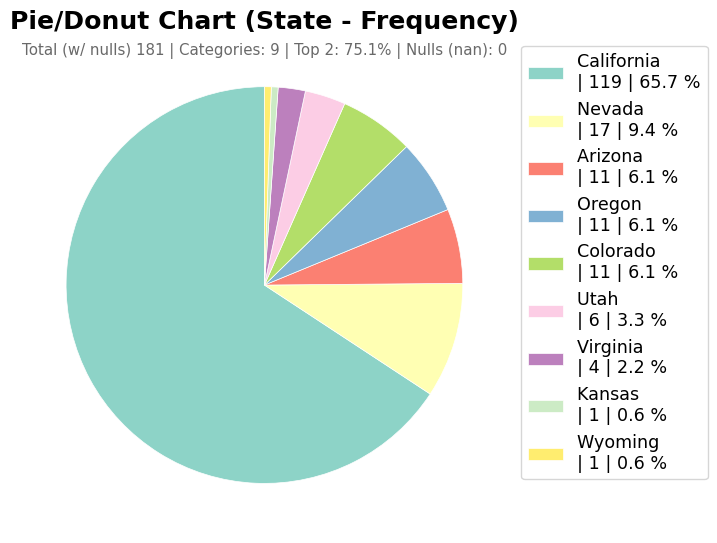

In [41]:
# c = get_colors_list('winter', 7)
# c
svc = df['State'].value_counts()
print(svc)
# svc
fig = plt_pie4(svc, scale=4, dropna=True, label_place='aside', order='desc', palette='set3')


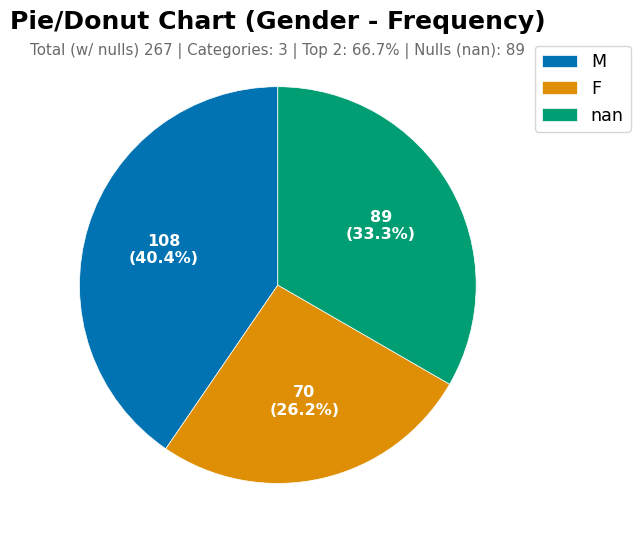

In [40]:
fig = plt_pie4(df['Gender'], value_counts=True, scale=4, dropna=False, label_place='int', order='ix_desc')

Male       70
Female    108
NaN        89
Name: count, dtype: int64


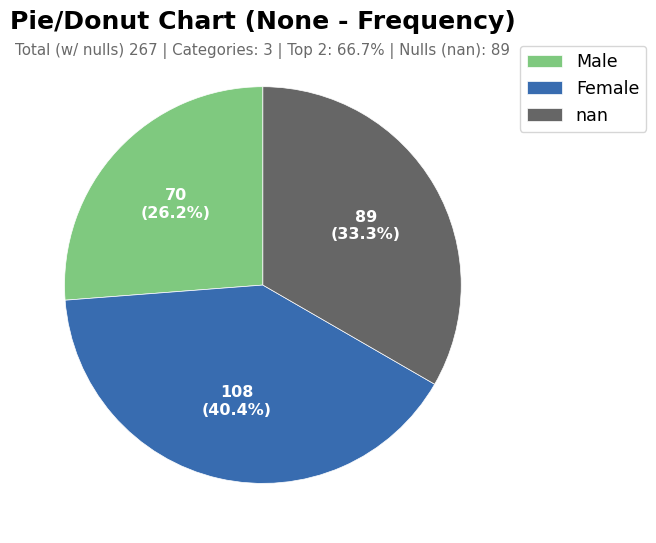

In [58]:
gvc = df['Gender'].value_counts(dropna=False, sort=False)
gvc.index = ['Male', 'Female', np.nan]
print(gvc)

fig = plt_pie4(gvc, scale=4, dropna=False, label_place='int', order='ix_desc', palette='Accent')

In [15]:
def plt_pie2(
    data: Union[pd.Series, np.ndarray, dict, list, set, pd.DataFrame],
    value_counts: Optional[bool] = False,
    nans: Optional[bool] = False,
    scale: Optional[int] = 2,
    figsize: Optional[tuple[float, float]] = None,
    title: Optional[str] = None,
    kind: Optional[str] = 'pie',
    label_place: Optional[str] = 'ext',
    palette: Optional[list] = 'colorblind',
    startangle: Optional[float] = -40,
    pct_decimals: Optional[int] = 1,
    label_rotate: Optional[float] = 0,
    legend_loc: Optional[str] = 'best',
) -> tuple[plt.Figure, plt.Axes]:
    """
    Generates pie or donut charts for categorical data visualization with customizable labels.

    This function creates a pie or donut chart from categorical data using matplotlib.
    It supports internal or external labels, custom palettes, and formatting options.

    Parameters:
        data (pd.Series, pd.DataFrame, dict, or list): Input data. If a list is provided,
            frequencies are counted automatically.
        scale (int): Chart scaling factor (1 to 6). Default is 2.
        title (str or None): Optional title for the chart.
        kind (str): Type of chart: 'pie' or 'donut'. Default is 'pie'.
        label_place (str): Placement of labels: 'ext' (external) or 'int' (internal).
        palette (list of str or None): List of color hex codes for categories.
        startangle (float): Starting angle in degrees for the first wedge.
        pct_decimals (int): Number of decimal places for percentage labels. Default is 2.
        label_rotate (float): Rotation angle for internal labels. Default is 0.
        legend_loc (str): Position of the legend ('best', 'upper right', etc.). Default is 'best'.

    Returns:
        tuple[matplotlib.figure.Figure, matplotlib.axes.Axes]: The Figure and Axes objects
            for further customization.

    Raises:
        ValueError: If data contains invalid values, if unsupported types are passed,
            if more than 9 categories are used, or if parameters like scale are out of range.
        TypeError: If data is not one of the accepted types.

    Examples:
        >>> import pandas as pd
        >>> data = pd.Series([25, 30, 20, 15, 10], index=['A', 'B', 'C', 'D', 'E'])
        >>> fig, ax = plt_pie(data, kind='donut', title='Donut Distribution')
        >>> plt.show()

        >>> data_list = ['A', 'B', 'A', 'C', 'B', 'B']
        >>> fig, ax = plt_pie(data_list, kind='pie', label_place='int')
        >>> plt.show()
    """
    # Convert to serie in case of np.ndarray, dict, list, set, pd.DataFrame
    sr = to_series(data)

    if value_counts:
        sr = sr.value_counts(sort=False, dropna=not nans)

    _validate_numeric_series(sr)

    # Validate kind parameter
    if kind.lower() not in ['pie', 'donut']:
        raise ValueError(f"Invalid 'kind' parameter: '{kind}'. Must be 'pie' or 'donut'.")
    
    # Validate maximum categories
    if len(sr) > 9:
        raise ValueError(f"Data contains {len(sr)} categories. "
                        "Maximum allowed is 9 categories.")
    
    # Build graphs size, and fonts size from scale, and validate scale from 1 to 9.
    if scale < 1 or scale > 9:
        raise ValueError(f"[ERROR] Invalid 'scale' value. Must between '1' and '9', not '{scale}'.")
    else:
        scale = round(scale)

    # Calculate figure dimensions
    if figsize is None:
        multiplier = 1.33333334 ** scale
        w_base, h_base = 4.45, 2.25
        width, height = w_base * multiplier, h_base * multiplier
        figsize = (width, height)
    else:
        width, height = figsize
    
    # Calculate font sizes based on figure width
    label_size = width * 1.25
    title_size = width * 1.57

    # Base fig definitions
    fig, ax = plt.subplots(figsize=figsize, subplot_kw=dict(aspect="equal"))

    # Configure wedge properties for donut  or pie chart
    wedgeprops = {}
    if kind.lower() == 'donut':
        wedgeprops = {'width': 0.54, 'edgecolor': 'white', 'linewidth': 1}
    else:
        wedgeprops = {'edgecolor': 'white', 'linewidth': 0.5}

    # Define colors
    color_palette = get_colors_list(palette, len(data))

    if label_place == 'ext':

        wedges, texts = ax.pie(sr, wedgeprops=wedgeprops, colors=color_palette, startangle=startangle)

        bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
        kw = dict(arrowprops=dict(arrowstyle="-"), bbox=bbox_props, zorder=0, va="center")

        # Build the labels. Annotations and legend in same label (External)
        labels = [
            f"{sr.loc[sr == value].index[0]}\n{value}\n({round(value / sr.sum() * 100, pct_decimals)} %)"
            for value in sr.values
        ]
        
        # Draw the annotations (labels)
        for i, p in enumerate(wedges):
            ang = (p.theta2 - p.theta1)/2. + p.theta1
            y = np.sin(np.deg2rad(ang))
            x = np.cos(np.deg2rad(ang))
            horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
            connectionstyle = f"angle,angleA=0,angleB={ang}"
            kw["arrowprops"].update({"connectionstyle": connectionstyle})
            ax.annotate(labels[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                    horizontalalignment=horizontalalignment, fontsize=label_size, **kw)
            
    elif label_place == 'int':
        label_size = label_size * 0.8
        legend_size = label_size * 1.1

        # autopct for internal annotations. A funtion to show both: absolute an pcts.
        format_string = f'%.{pct_decimals}f%%'

        def make_autopct(values, fmt_str):
            value_iterator = iter(values)
            
            def my_autopct(pct):
                absolute_value = next(value_iterator)
                percentage_string = fmt_str % pct
                return f"{absolute_value}\n({percentage_string})"  
            
            return my_autopct
        
        autopct_function = make_autopct(sr.values, format_string)
        
        ax.pie(x=sr,
            colors=color_palette,
            startangle=startangle,
            autopct=autopct_function,
            wedgeprops=wedgeprops,
            textprops={'size': label_size,
                        'color': 'w',
                        'rotation': label_rotate,
                        'weight': 'bold'})
        
        ax.legend(sr.index,
                loc=legend_loc,
                bbox_to_anchor=(1, 0, 0.2, 1),
                prop={'size': legend_size})

    else:
        raise ValueError(f"Invalid labe_place parameter. Must be 'ext' or 'int', not '{label_place}'.")
            
    # Build title
    if not title:
        title = f"Pie/Donut Chart - ({sr.name})"
    ax.set_title(title, fontdict={'size': title_size, 'weight': 'bold'})

    return fig, ax

In [16]:
df.columns
# sr_counted = df['Type of property'].value_counts()

Index(['Building', 'Year of sale', 'Month of sale', 'Type of property',
       'Property #', 'Area (ft.)', 'Price', 'Status', 'Customer ID', 'Entity',
       'Name', 'Surname', 'Age at time of purchase', 'Interval', 'Y', 'M', 'D',
       'Gender', 'Country', 'State', 'Purpose', 'Deal satisfaction',
       'Mortgage', 'Source'],
      dtype='object')

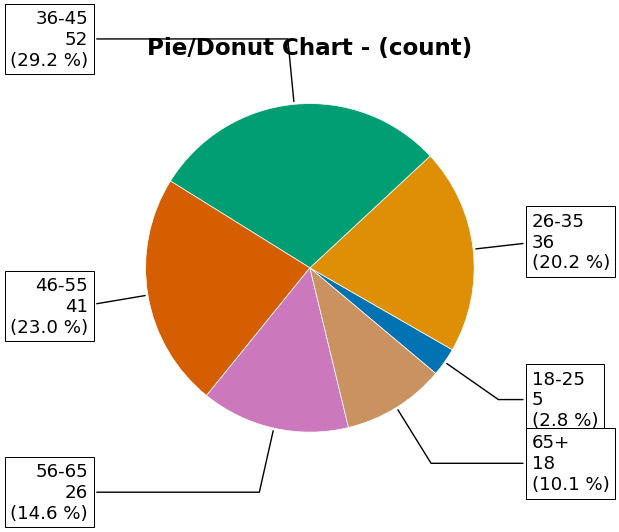

In [17]:
fig = plt_pie2(df['Interval'], value_counts=True, scale=3, label_place='ext')
# fig = plt_pie2(df['Interval'], value_counts=True, scale=3, nans=True, label_place='ext')
# fig = plt_pie2(sr_counted, scale=3, label_place='ext')

In [18]:
sr = to_series(df['Gender'])
sr = sr.value_counts(sort=False, dropna=True)
sr.values.sum()
sr.sum()

np.int64(178)

In [19]:
## out labels
def plt_pie3(
    data: Union[pd.Series, np.ndarray, dict, list, set, pd.DataFrame],
    value_counts: Optional[bool] = False,
    sort: Optional[bool] = True,
    dropna: Optional[bool] = True,
    scale: Optional[int] = 1,
    figsize: Optional[tuple[float, float]] = None,
    title: Optional[str] = None,
    kind: Optional[str] = 'pie',
    label_place: Optional[str] = 'ext',
    palette: Optional[list] = 'colorblind',
    startangle: Optional[float] = -40,
    pct_decimals: Optional[int] = 1,
    label_rotate: Optional[float] = 0,
    legend_loc: Optional[str] = 'best',
) -> tuple[plt.Figure, plt.Axes]:
    """
    Generates a pie or donut chart with customizable label placement and styling.

    This function creates a pie or donut chart from categorical data using matplotlib.
    It supports internal, external, or aside label placement with optional percentage
    and value annotations.

    Parameters:
        data (Union[pd.Series, np.ndarray, dict, list, set, pd.DataFrame],):
            Input data be converted to a Series using `to_series`.
        value_counts (bool, optional): If True, counts occurrences of each category.
            Default is False.
        sort (bool, optional): If True and `value_counts=True`, sorts categories by frequency.
            Default is True.
        nans (bool, optional): If True, includes NaN values in the count. Default is False.
        scale (int, optional): Chart scaling factor (1 to 9). Affects figure size and font sizes.
            Default is 1.
        figsize (tuple, optional): Width and height of the figure in inches. Overrides `scale`.
            Default is None.
        title (str, optional): Chart title. If not provided, a default title is used.
        kind (str, optional): Type of chart to generate. Options:
            - 'pie': standard pie chart.
            - 'donut': donut chart with a hollow center.
        label_place (str, optional): Placement of labels. Options:
            - 'ext': external labels connected by arrows.
            - 'int': internal labels within each segment (shows absolute values and percentages).
            - 'aside': internal labels and a legend with extended labels on the side.
        palette (list or str, optional): Color palette for segments. If a string, uses a predefined
            palette (e.g., 'set2' or 'viridis'). Default is 'colorblind'.
        startangle (float, optional): Starting angle (in degrees) for the first wedge.
            Default is -40.
        pct_decimals (int, optional): Number of decimal places to display in percentage values.
            Default is 1.
        label_rotate (float, optional): Rotation angle for internal labels (only applies if
            `label_place='int'`). Default is 0.
        legend_loc (str, optional): Position of the legend (if displayed). See valid options in
            `matplotlib.legend`. Default is 'best'.

    Returns:
        tuple[plt.Figure, plt.Axes]: A tuple containing:
            - fig: The Matplotlib Figure object.
            - ax: The Matplotlib Axes object for further customization.

    Raises:
        TypeError: If input data is not a pandas Series or DataFrame.
        ValueError: If `kind` is not 'pie' or 'donut'.
        ValueError: If more than 12 categories are provided.
        ValueError: If `scale` is not between 1 and 9.

    Notes:
        - This function uses `to_series` to convert DataFrame or other data types into a Series.
        - It supports rich annotations and color palettes for better visual clarity.
        - Maximum of 12 categories allowed for readability.

    Example:
        >>> import pandas as pd
        >>> data = pd.Series(['A', 'B', 'A', 'C', 'B', 'B', 'A', 'A', 'B', 'C'])
        >>> fig, ax = plt_pie3(data, kind='donut', label_place='aside', title='Distribution of Categories')
        >>> plt.show()
    """

    # Convert to serie in case of np.ndarray, dict, list, set, or pd.DataFrame
    sr = to_series(data)
    n_nans = sr.isna().sum()                    # original number of nans, for statistical subtitle info

    if dropna:
        sr = sr.dropna()                        # Drop NaN values if dropna is True
        total_label = 'Total (without Nulls):'  # for statistical subtitle info
    else:
        total_label = 'Total (with Nulls):'

    if value_counts:
        sr = sr.value_counts(sort=sort, dropna=dropna)

    _validate_numeric_series(sr)

    # Validate kind parameter
    if kind.lower() not in ['pie', 'donut']:
        raise ValueError(f"Invalid 'kind' parameter: '{kind}'. Must be 'pie' or 'donut'.")
    
    # Validate maximum categories
    if len(sr) > 12:
        raise ValueError(f"Data contains {len(sr)} categories. "
                        "Maximum allowed is 12 categories.")
    
    # Build graphs size, and fonts size from scale, and validate scale from 1 to 9.
    if scale < 1 or scale > 9:
        raise ValueError(f"[ERROR] Invalid 'scale' value. Must between '1' and '9', not '{scale}'.")
    else:
        scale = round(scale)

    # Calculate figure dimensions
    if figsize is None:
        multiplier = scale + 7.5
        w_base, h_base = 1, 0.56
        width, height = w_base * multiplier, h_base * multiplier
        figsize = (width, height)
    else:
        width, height = figsize
    
    # Calculate font sizes based on figure width
    label_size = width * 1.25
    title_size = width * 1.57

    # Base fig definitions
    fig, ax = plt.subplots(figsize=figsize, subplot_kw=dict(aspect="equal"))

    # Configure wedge properties for donut  or pie chart
    wedgeprops = {}
    if kind.lower() == 'donut':
        wedgeprops = {'width': 0.54, 'edgecolor': 'white', 'linewidth': 1}
    else:
        wedgeprops = {'edgecolor': 'white', 'linewidth': 0.5}

    # Define colors
    color_palette = get_colors_list(palette, len(sr))

    if label_place == 'ext':

        wedges, texts = ax.pie(sr, wedgeprops=wedgeprops, colors=color_palette, startangle=startangle)

        bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
        kw = dict(arrowprops=dict(arrowstyle="-"), bbox=bbox_props, zorder=0, va="center")

        # Build the labels. Annotations and legend in same label (External)
        labels = [
            f"{sr.loc[sr == value].index[0]}\n{value}\n({round(value / sr.sum() * 100, pct_decimals)} %)"
            for value in sr.values
        ]
        
        # Draw the annotations (labels)
        for i, p in enumerate(wedges):
            ang = (p.theta2 - p.theta1)/2. + p.theta1
            y = np.sin(np.deg2rad(ang))
            x = np.cos(np.deg2rad(ang))
            horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
            connectionstyle = f"angle,angleA=0,angleB={ang}"
            kw["arrowprops"].update({"connectionstyle": connectionstyle})
            ax.annotate(labels[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                    horizontalalignment=horizontalalignment, fontsize=label_size, **kw)
            
    elif label_place == 'int' or label_place == 'aside':
        label_size = label_size * 0.8
        legend_size = label_size * 1.1
        
        # Set autopct and legends, different for 'int' and 'aside' label_place
        if label_place == 'int':
            # autopct for internal annotations. A funtion to show both: absolute an pcts.
            format_string = f'%.{pct_decimals}f%%'

            def _make_autopct(values, fmt_str):     # A python Closuer
                value_iterator = iter(values)
                
                def my_autopct(pct):
                    absolute_value = next(value_iterator)
                    percentage_string = fmt_str % pct
                    return f"{absolute_value}\n({percentage_string})"  
                
                return my_autopct
            
            autopct_function = _make_autopct(sr.values, format_string)

            legends = sr.index

        else:                           # elif aside:  Valid autopct and legends in case of 'aside' label_place
            autopct_function = None     # No data inside de pie or donut
            # Custom legends w/labels values and pct aside of the pie or donut
            total = sr.values.sum()         
            legends = [f"{sr.index[i]} \n| {value} | {round(value / total * 100, pct_decimals)} %"
                    for i, value in enumerate(sr.values)] 

        ax.pie(x=sr,
            colors=color_palette,
            startangle=startangle,
            autopct=autopct_function,
            wedgeprops=wedgeprops,
            textprops={'size': label_size,
                        'color': 'w',
                        'rotation': label_rotate,
                        'weight': 'bold'})
        
        ax.legend(legends,
                loc=legend_loc,
                bbox_to_anchor=(1, 0, 0.2, 1),
                prop={'size': legend_size})

    else:
        raise ValueError(f"Invalid labe_place parameter. Must be 'ext', 'int' or 'aside', not '{label_place}'.")
            
    # Build title
    if not title:
        title = f"Pie/Donut Chart - ({sr.name})"

    # Enhanced subtitle with statistics
    total_items = sr.sum()                  # Total items in the series
    n_categories = len(sr)                  # len(categories)
    top_2_pct = (sr.head(2).sum() / total_items * 100) if n_categories >= 3 else (sr.sum() / total_items * 100)

    subtitle = f"{total_label} {total_items:,} | Categories: {n_categories} | Top 2: {top_2_pct:.1f}% | Nulls: {n_nans}"

    # Set the title and subtitle
    ax.set_title(title, fontdict={'size': title_size, 'weight': 'bold'})
    ax.text(0, 1.18, subtitle, ha='center', va='center', fontsize=title_size * 0.6, color='dimgray')

    return fig, ax

In [20]:
## out labels
def plt_pie3(
    data: Union[pd.Series, np.ndarray, dict, list, set, pd.DataFrame],
    value_counts: Optional[bool] = False,
    sort: Optional[bool] = True,
    dropna: Optional[bool] = True,
    scale: Optional[int] = 1,
    figsize: Optional[tuple[float, float]] = None,
    title: Optional[str] = None,
    kind: Optional[str] = 'pie',
    label_place: Optional[str] = 'ext',
    palette: Optional[list] = 'colorblind',
    startangle: Optional[float] = -40,
    pct_decimals: Optional[int] = 1,
    label_rotate: Optional[float] = 0,
    legend_loc: Optional[str] = 'best',
) -> tuple[plt.Figure, plt.Axes]:
    """
    Generates a pie or donut chart with customizable label placement and styling.

    This function creates a pie or donut chart from categorical data using matplotlib.
    It supports internal, external, or aside label placement with optional percentage
    and value annotations.

    Parameters:
        data (Union[pd.Series, np.ndarray, dict, list, set, pd.DataFrame],):
            Input data be converted to a Series using `to_series`.
        value_counts (bool, optional): If True, counts occurrences of each category.
            Default is False.
        sort (bool, optional): If True and `value_counts=True`, sorts categories by frequency.
            Default is True.
        nans (bool, optional): If True, includes NaN values in the count. Default is False.
        scale (int, optional): Chart scaling factor (1 to 9). Affects figure size and font sizes.
            Default is 1.
        figsize (tuple, optional): Width and height of the figure in inches. Overrides `scale`.
            Default is None.
        title (str, optional): Chart title. If not provided, a default title is used.
        kind (str, optional): Type of chart to generate. Options:
            - 'pie': standard pie chart.
            - 'donut': donut chart with a hollow center.
        label_place (str, optional): Placement of labels. Options:
            - 'ext': external labels connected by arrows.
            - 'int': internal labels within each segment (shows absolute values and percentages).
            - 'aside': internal labels and a legend with extended labels on the side.
        palette (list or str, optional): Color palette for segments. If a string, uses a predefined
            palette (e.g., 'set2' or 'viridis'). Default is 'colorblind'.
        startangle (float, optional): Starting angle (in degrees) for the first wedge.
            Default is -40.
        pct_decimals (int, optional): Number of decimal places to display in percentage values.
            Default is 1.
        label_rotate (float, optional): Rotation angle for internal labels (only applies if
            `label_place='int'`). Default is 0.
        legend_loc (str, optional): Position of the legend (if displayed). See valid options in
            `matplotlib.legend`. Default is 'best'.

    Returns:
        tuple[plt.Figure, plt.Axes]: A tuple containing:
            - fig: The Matplotlib Figure object.
            - ax: The Matplotlib Axes object for further customization.

    Raises:
        TypeError: If input data is not a pandas Series or DataFrame.
        ValueError: If `kind` is not 'pie' or 'donut'.
        ValueError: If more than 12 categories are provided.
        ValueError: If `scale` is not between 1 and 9.

    Notes:
        - This function uses `to_series` to convert DataFrame or other data types into a Series.
        - It supports rich annotations and color palettes for better visual clarity.
        - Maximum of 12 categories allowed for readability.

    Example:
        >>> import pandas as pd
        >>> data = pd.Series(['A', 'B', 'A', 'C', 'B', 'B', 'A', 'A', 'B', 'C'])
        >>> fig, ax = plt_pie3(data, kind='donut', label_place='aside', title='Distribution of Categories')
        >>> plt.show()
    """

    # Convert to serie in case of np.ndarray, dict, list, set, or pd.DataFrame
    sr = to_series(data)
    n_nans = sr.isna().sum()                    # original number of nans, for statistical subtitle info

    if dropna:
        sr = sr.dropna()                        # Drop NaN values if dropna is True
        total_label = 'Total (without Nulls):'  # for statistical subtitle info
    else:
        total_label = 'Total (with Nulls):'

    if value_counts:
        sr = sr.value_counts(sort=sort, dropna=dropna)

    _validate_numeric_series(sr)

    # Validate kind parameter
    if kind.lower() not in ['pie', 'donut']:
        raise ValueError(f"Invalid 'kind' parameter: '{kind}'. Must be 'pie' or 'donut'.")
    
    # Validate maximum categories
    if len(sr) > 12:
        raise ValueError(f"Data contains {len(sr)} categories. "
                        "Maximum allowed is 12 categories.")
    
    # Build graphs size, and fonts size from scale, and validate scale from 1 to 9.
    if scale < 1 or scale > 9:
        raise ValueError(f"[ERROR] Invalid 'scale' value. Must between '1' and '9', not '{scale}'.")
    else:
        scale = round(scale)

    # Calculate figure dimensions
    if figsize is None:
        multiplier = scale + 7.5
        w_base, h_base = 1, 0.56
        width, height = w_base * multiplier, h_base * multiplier
        figsize = (width, height)
    else:
        width, height = figsize
    
    # Calculate font sizes based on figure width
    label_size = width * 1.25
    title_size = width * 1.57

    # Base fig definitions
    fig, ax = plt.subplots(figsize=figsize, subplot_kw=dict(aspect="equal"))

    # Configure wedge properties for donut  or pie chart
    wedgeprops = {}
    if kind.lower() == 'donut':
        wedgeprops = {'width': 0.54, 'edgecolor': 'white', 'linewidth': 1}
    else:
        wedgeprops = {'edgecolor': 'white', 'linewidth': 0.5}

    # Define colors
    color_palette = get_colors_list(palette, len(sr))

    if label_place == 'ext':

        wedges, texts = ax.pie(sr, wedgeprops=wedgeprops, colors=color_palette, startangle=startangle)

        bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
        kw = dict(arrowprops=dict(arrowstyle="-"), bbox=bbox_props, zorder=0, va="center")

        # Build the labels. Annotations and legend in same label (External)
        labels = [
            f"{sr.loc[sr == value].index[0]}\n{value}\n({round(value / sr.sum() * 100, pct_decimals)} %)"
            for value in sr.values
        ]
        
        # Draw the annotations (labels)
        for i, p in enumerate(wedges):
            ang = (p.theta2 - p.theta1)/2. + p.theta1
            y = np.sin(np.deg2rad(ang))
            x = np.cos(np.deg2rad(ang))
            horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
            connectionstyle = f"angle,angleA=0,angleB={ang}"
            kw["arrowprops"].update({"connectionstyle": connectionstyle})
            ax.annotate(labels[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                    horizontalalignment=horizontalalignment, fontsize=label_size, **kw)
            
    elif label_place == 'int' or label_place == 'aside':
        label_size = label_size * 0.8
        legend_size = label_size * 1.1
        
        # Set autopct and legends, different for 'int' and 'aside' label_place
        if label_place == 'int':
            # autopct for internal annotations. A funtion to show both: absolute an pcts.
            format_string = f'%.{pct_decimals}f%%'

            def _make_autopct(values, fmt_str):     # A python Closuer
                value_iterator = iter(values)
                
                def my_autopct(pct):
                    absolute_value = next(value_iterator)
                    percentage_string = fmt_str % pct
                    return f"{absolute_value}\n({percentage_string})"  
                
                return my_autopct
            
            autopct_function = _make_autopct(sr.values, format_string)

            legends = sr.index

        else:                           # elif aside:  Valid autopct and legends in case of 'aside' label_place
            autopct_function = None     # No data inside de pie or donut
            # Custom legends w/labels values and pct aside of the pie or donut
            total = sr.values.sum()         
            legends = [f"{sr.index[i]} \n| {value} | {round(value / total * 100, pct_decimals)} %"
                    for i, value in enumerate(sr.values)] 

        ax.pie(x=sr,
            colors=color_palette,
            startangle=startangle,
            autopct=autopct_function,
            wedgeprops=wedgeprops,
            textprops={'size': label_size,
                        'color': 'w',
                        'rotation': label_rotate,
                        'weight': 'bold'})
        
        ax.legend(legends,
                loc=legend_loc,
                bbox_to_anchor=(1, 0, 0.2, 1),
                prop={'size': legend_size})

    else:
        raise ValueError(f"Invalid labe_place parameter. Must be 'ext', 'int' or 'aside', not '{label_place}'.")
            
    # Build title
    if not title:
        title = f"Pie/Donut Chart - ({sr.name})"

    # Enhanced subtitle with statistics
    total_items = sr.sum()                  # Total items in the series
    n_categories = len(sr)                  # len(categories)
    top_2_pct = (sr.head(2).sum() / total_items * 100) if n_categories >= 3 else (sr.sum() / total_items * 100)

    subtitle = f"{total_label} {total_items:,} | Categories: {n_categories} | Top 2: {top_2_pct:.1f}% | Nulls: {n_nans}"

    # Set the title and subtitle
    ax.set_title(title, fontdict={'size': title_size, 'weight': 'bold'})
    ax.text(0, 1.18, subtitle, ha='center', va='center', fontsize=title_size * 0.6, color='dimgray')

    return fig, ax

In [21]:
df.columns

Index(['Building', 'Year of sale', 'Month of sale', 'Type of property',
       'Property #', 'Area (ft.)', 'Price', 'Status', 'Customer ID', 'Entity',
       'Name', 'Surname', 'Age at time of purchase', 'Interval', 'Y', 'M', 'D',
       'Gender', 'Country', 'State', 'Purpose', 'Deal satisfaction',
       'Mortgage', 'Source'],
      dtype='object')

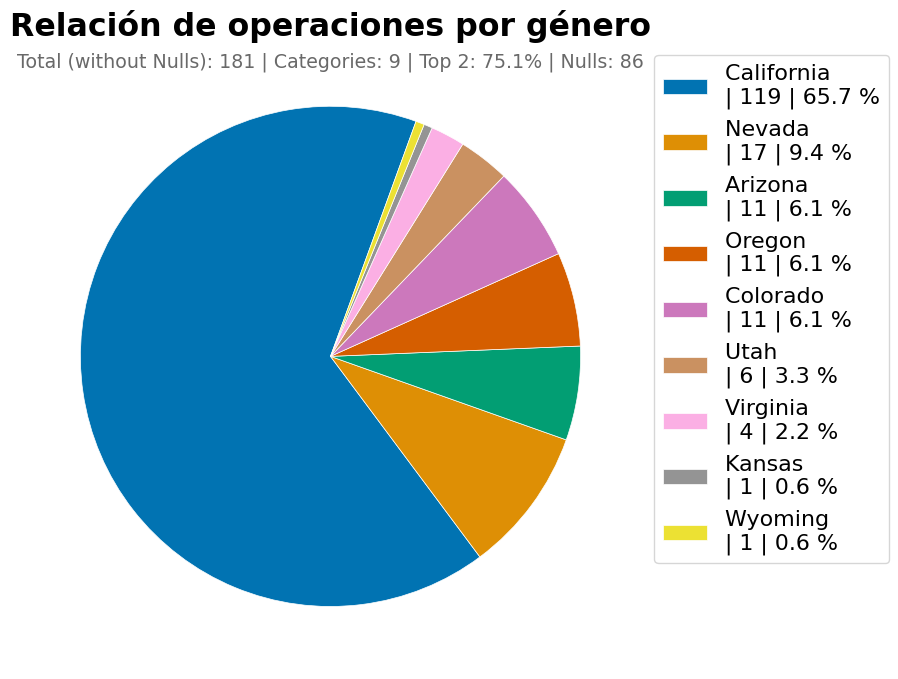

In [22]:
fig = plt_pie3(df['State'], value_counts=True, scale=7, label_place='aside',
                title='Relación de operaciones por género', dropna=True, startangle=70)

In [23]:
data_text = {'Year': [2020, 2021, 2022], 'Sales': [100, 150, 200]}
df_txt = pd.DataFrame(data_text)

# Create a plot
ax = df.plot(x='Year', y='Sales', kind='line', marker='o')

# Add text annotation
ax.text(2021, 150, 'Peak Sales', fontsize=12, color='red', ha='right')

plt.show()
# Example 2: Styling Text

# Copiar el código
# ax.text(2022, 200, 'End of Data', fontsize=14, color='blue', 
#         ha='right', va='bottom', rotation=45, bbox=dict(facecolor='yellow', alpha=0.5))
# # Key Parameters for ax.text():
# fontsize: Size of the text.
# color: Text color.
# ha / va: Horizontal/Vertical alignment ('center', 'left', 'right', 'top', 'bottom').
# rotation: Angle of rotation for the text.
# bbox: A dictionary to style the background box (e.g., facecolor, edgecolor, alpha).
# This method is great for adding annotations or labels to enhance the readability of your plots!



KeyError: 'Year'

In [ ]:
# def get_fdt(
#         data: Union[pd.Series, np.ndarray, dict, list, pd.DataFrame],
#         value_counts: Optional[bool] = False,
#         pcts: Optional[bool] = True,
#         plain_relatives: Optional[bool] = True,
#         fmt_values: Optional[bool] = False,
#         sort: Optional[str] = 'desc',
#         nans: Optional[str] = 'drop'
# ) -> pd.DataFrame:
#     '''
#     Generata a Frequency Distribution Table (fdt)

#     data: puede ser ya con el value_counts() hecho o no
#     sort: 'desc', 'asc', 'ix_asc', 'ix_desc', para como queremos que sea vea el orden por valores o por indice
#     nans: 'drop', 'last', 'sort'
#     '''
#     columns = [
#         'Frequency',
#         'Cumulative Frequency',
#         'Relative Frequency',
#         'Cumulative Relative Freq.',
#         'Relative Freq. [%]',
#         'Cumulative Freq. [%]'
#     ]
    
#     sr = to_series(data)
#     # nans = sr.isna().sum()        # FUTURE to think if nans is interesting to see here or in a pareto u other categorical chart

#     if value_counts:
#         sr = sr.value_counts()

#     fdt = pd.DataFrame(sr)
#     fdt.columns = [columns[0]]
#     fdt[columns[1]] = fdt['Frequency'].cumsum()
#     fdt[columns[2]] = fdt['Frequency'] / fdt['Frequency'].sum()
#     fdt[columns[3]] = fdt['Relative Frequency'].cumsum()
#     fdt[columns[4]] = fdt['Relative Frequency'] * 100
#     fdt[columns[5]] = fdt['Cumulative Relative Freq.'] * 100

#     if not pcts:                    # Don't return percentage columns
#         fdt = fdt[columns[0:4]]
    
#     if not plain_relatives:         # Don't return relative and plain cumulative
#         fdt = fdt[[columns[0], columns[4], columns[5]]]

#     # if fmt_values:
#     #     fdt = fdt.map(_fmt_value_for_pd)
        
#     match sort:
#         case 'asc':
#             return fdt.sort_values(by=columns[0])
#         case 'ix_asc':
#             return fdt.sort_index()
#         case 'ix_desc':
#             return fdt.sort_index(ascending=False)
#         case _:
#             return fdt